<a href="https://colab.research.google.com/github/the-bucketless/iihf/blob/main/ww_goal_location_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal Locations from Women's Worlds  

This notebook is meant as a quick and simple example of how the IIHF data found in my [github repo](https://github.com/the-bucketless/iihf.git) can be used. It'll look at where in the net goals from the Women's Worlds have been scored over the years.

## Pulling in the Data

The first step is to grab the data from the repo. The following cell will pull in everything from the repo (including this notebook because recursion is fun). Afterward, the files can be located in the pane to the left.

In [1]:
!git clone https://github.com/the-bucketless/iihf.git

Cloning into 'iihf'...
remote: Enumerating objects: 890, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 890 (delta 129), reused 246 (delta 105), pack-reused 607
Receiving objects: 100% (890/890), 6.23 MiB | 8.02 MiB/s, done.
Resolving deltas: 100% (451/451), done.


## Imports

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## DataFrame of Relevant Data

Now that all the data can be easily accessed, let's put anything needed in a pandas DataFrame. For this example, the only files we need are the goals files from all the Women's World Championships.

In [3]:
# The goals files have file names of the form goals{year}.
# We only need the top level Women's Worlds tournaments
# which are in the ww/ww directory.
ww_files = glob("/content/iihf/data/ww/ww/goals*.csv")

# We'll concatenate all of the csv files into a single DataFrame 
# while keeping track of which year the goals are from.
df = pd.concat(
    [
        pd.read_csv(ww_file)
        # Strip any non-numeric characters from the file path
        # to add a column for what year the goals are from.
        .assign(year=int("".join(c for c in ww_file if c.isdigit())))
        for ww_file in ww_files
    ],
    ignore_index=True,
)

## Checking the Data

With our DataFrame assembled, we can check out what the data looks like. Let's see what the first goal from every tournament was.

In [4]:
ww_by_year = df.groupby("year", as_index=False)

ww_by_year.first()

,year,shot_chart_url,period,team,shooter_number,opponent,goalie_number,x,y,team1,team2,game_url
0,2019,https://www.iihf.com//pdf/510/ihw510b01_77a_2_0,2.0,GER,16.0,SWE,1.0,4.002305,2.135536,GER,SWE,https://www.iihf.com//en/events/2019/ww/gamece...
1,2021,https://www.iihf.com//pdf/929/ihw929b01_77a_3_0,1.0,CZE,9.0,DEN,30.0,1.615729,0.907237,CZE,DEN,https://www.iihf.com//en/events/2021/ww/gamece...
2,2022,https://www.iihf.com//pdf/164/ihw164a01_77a_3_0,1.0,USA,12.0,JPN,30.0,5.344756,3.632701,JPN,USA,https://www.iihf.com//en/events/2022/ww/gamece...


We can also look at the goals per game at each tournament.

In [5]:
(
    ww_by_year
    .agg(
        n_goals=("year", "count"), 
        n_games=("game_url", "nunique"),
    )
    .assign(goals_per_game=lambda df_: df_.n_goals / df_.n_games)
)

,year,n_goals,n_games,goals_per_game
0,2019,158,29,5.448276
1,2021,145,31,4.677419
2,2022,188,30,6.266667


And we should take a look at what the coordinates of the goals look like.

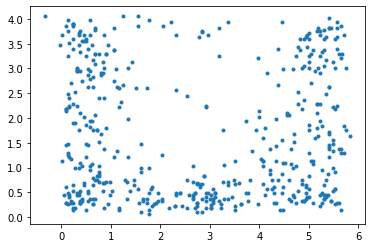

In [6]:
plt.plot(df.x, df.y, ".");

The dots should be in the range of 0 to 6 on the x-axis and 0 to 4 on the y-axis (a net is 6x4'). However, there are a couple shot charts from the IIHF that appear to have goals outside the net. That could very well mean that I'm misinterpreting how these are being recorded in their PDFs, but I haven't figured out how.  

Also, it may have been a better idea to name the columns y and z instead of x and y to allow for them to match the coordinates typically used on a rink. But at least this way is sensible for how we're going to plot things.

## Drawing a Net

Rather than just plot a bunch of points on a blank space, let's draw the goals between the posts of a net. There are a few ways to do this, I'm going to do it by setting the corner coordinates of the posts and using matplotlib's fill function to color them in. I'm also leaving square corners on the net instead of elbows for simplicity.  We're going to need to do this a few times, so we'll throw it in a function that we can call each time.

In [7]:
NET_WIDTH = 6
NET_HEIGHT = 4
POST_WIDTH = (2 + 3 / 8) / 12


def draw_net(ax=None):
    if ax is None:
        ax = plt.gca()

    # The posts are drawn going from bottom left to the top 
    # then across and, eventually, all the way back around.
    ax.fill(
        [
            -POST_WIDTH, -POST_WIDTH, NET_WIDTH + POST_WIDTH, NET_WIDTH + POST_WIDTH, 
            NET_WIDTH, NET_WIDTH, 0, 0,
        ],
        [
            0, NET_HEIGHT + POST_WIDTH, NET_HEIGHT + POST_WIDTH, 0,
            0, NET_HEIGHT, NET_HEIGHT, 0,
        ],
        color="red",
    )

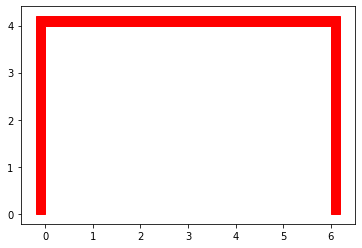

In [8]:
draw_net()

Before we get to the goals by year, let's make sure we're plotting things in the right spot. We'll grab the goals from the 2022 final and make sure they match the goals as they're shown in the IIHF PDF. This can be accessed by the link in the shot_chart_url column. All the goals occurred in the 2nd period.

In [9]:
# Games are scraped in the order their URLs are found. Typically, 
# this should result in the final being the last game found in the 
# DataFrame, but it might not always be a safe assumption to make.
last_game_url = df.query("year == 2022").game_url.iloc[-1]
last_game = df.query("game_url == @last_game_url")

last_game

,shot_chart_url,period,team,shooter_number,opponent,goalie_number,x,y,team1,team2,game_url,year
488,https://www.iihf.com//pdf/164/ihw164131_77a_3_0,2.0,USA,11.0,CAN,35.0,4.449788,0.485183,USA,CAN,https://www.iihf.com//en/events/2022/ww/gamece...,2022
489,https://www.iihf.com//pdf/164/ihw164131_77a_3_0,2.0,CAN,19.0,USA,29.0,5.605786,0.293087,USA,CAN,https://www.iihf.com//en/events/2022/ww/gamece...,2022
490,https://www.iihf.com//pdf/164/ihw164131_77a_3_0,2.0,CAN,19.0,USA,29.0,5.270175,3.325452,USA,CAN,https://www.iihf.com//en/events/2022/ww/gamece...,2022


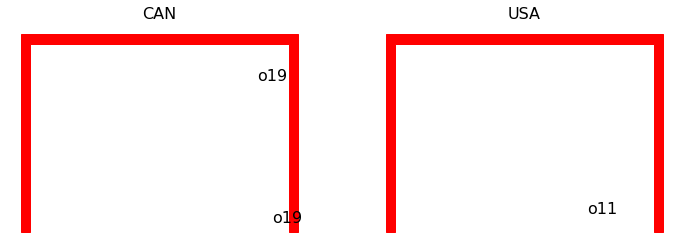

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

teams = sorted(last_game.team.unique())

for team, ax in zip(teams, axs.flatten()):
    draw_net(ax)
    ax.set_title(team, fontsize=16)
    ax.axis("off")

for row in last_game.itertuples():
    ax_idx = teams.index(row.team)
    axs[ax_idx].text(
        row.x, row.y, f"o{int(row.shooter_number)}", 
        ha="left", va="center", color="black",
        fontsize=16,
    )

Looks good to me.

## Goals by Year

Finally, let's take a look at where pucks have been finding their way past goalies by year. We'll also throw in a plot that contains all the goals from every year for good measure. I'm choosing to use kernel density estimate plots (kdeplots) for this.

Since I'm only interested in shots that beat goaltenders, we'll also need to remove empty netters. The goalie's number is listed as -1 for empty net goals, so we'll remove those from the data.  

And I'll make the number of levels in the kdeplots a parameter you can play with, in case that interests you.

In [11]:
levels = 15    #@param {type: "number"}

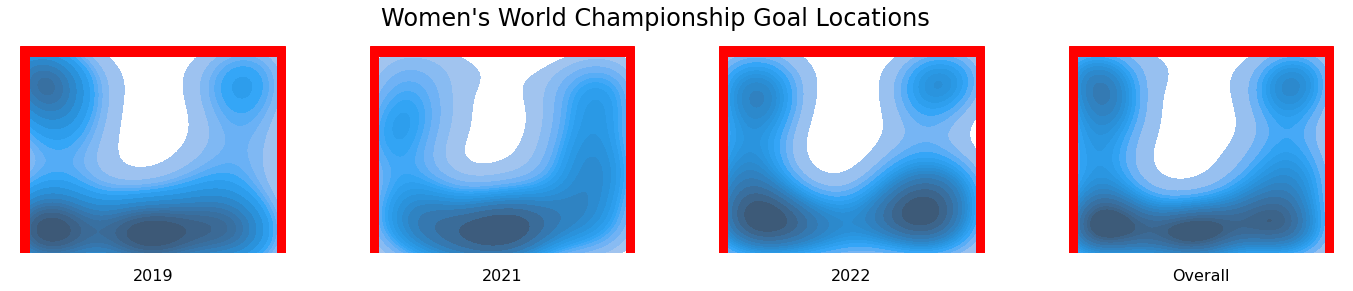

In [12]:
# Remove empty net goals.
goals_on_goalies = df.query("goalie_number != -1")

# One Axes object for each year plus one for the overall totals.
years = sorted(df.year.unique())
n_cols = len(years) + 1

summary_title = "Overall"

fig, axs = plt.subplots(1, n_cols, figsize=(n_cols * 6, 4), facecolor="white")
fig.suptitle("Women's World Championship Goal Locations", fontsize=24)

for year, ax in zip(years + [summary_title], axs.flatten()):
    draw_net(ax)
    ax.axis("off")
    ax.set_title(year, fontsize=16, y=-0.1, va="top")

    sns.kdeplot(
        x="x", y="y", ax=ax, levels=levels, shade=True, clip=[(0, NET_WIDTH), (0, NET_HEIGHT)],
        data=goals_on_goalies.query("year == @year") if year != summary_title else goals_on_goalies, 
    )

Looks like a lot of goals in the bottom part of the net, not so many directed at the goalie's chest/head. Five hole goals may also have been less common in 2022 than in previous years.